In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
import cupy as cp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


from collections import defaultdict
from nltk.corpus import stopwords
import nltk
import time

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)
from src.loader import NewsDataLoader
from src.utils import preprocess_text
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mekbib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Initialize Dataloader

In [2]:
ndl = NewsDataLoader("../data")
data = ndl.load_data()
traffic = ndl.load_traffic()
domain = ndl.load_domain_location()

# How similar are keywords in the headline/title compared to keywords in the news body across sites? 

In [16]:
from src.utils import extract_domain


data["Domain"] = data["url"].map(extract_domain)
data_traffic = data.merge(traffic, left_on="Domain", right_on="Domain")
data_traffic_unique_asc = data_traffic.sort_values(by='GlobalRank', ascending=True).drop_duplicates(subset='Domain').reset_index(drop=True)
data_traffic_unique_asc= data_traffic_unique_asc.groupby("source_name").first("GlobalRank").reset_index()

In [4]:
stop_words = set(stopwords.words('english'))


data['cleaned_title'] = data['title'].map(lambda x: preprocess_text(x, stop_words))
data['cleaned_content'] = data['content'].map(lambda x: preprocess_text(x, stop_words))

combined_text = pd.concat([data['cleaned_title'], data['cleaned_content']])

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(combined_text)

title_tfidf = tfidf_vectorizer.transform(data['cleaned_title'])
content_tfidf = tfidf_vectorizer.transform(data['cleaned_content'])

data['similarity'] = [cosine_similarity(title_tfidf[i], content_tfidf[i]).flatten()[0] for i in range(len(data))]

site_similarity = data.groupby('source_name')['similarity'].mean().reset_index()
site_similarity.columns = ['Source Name', 'Average Title-Content Similarity']
site_similarity.sort_values(by='Average Title-Content Similarity', ascending=False)

,Source Name,Average Title-Content Similarity
26,The Verge,0.773013
11,ETF Daily News,0.622353
9,Deadline,0.413583
16,GlobeNewswire,0.382301
18,Marketscreener.com,0.354881
0,ABC News,0.354594
4,BBC News,0.338615
7,CNA,0.325279
23,The Indian Express,0.294212
24,The Punch,0.291455


In [21]:
data_traffic_siteSimilarity = pd.merge(site_similarity,data_traffic_unique_asc,left_on="Source Name",right_on="source_name")

In [24]:
data_traffic_siteSimilarity["Average Title-Content Similarity"].corr(data_traffic_siteSimilarity["GlobalRank"])

0.4935872315474952

# Topic modelling

## categorise the title/content into a known set of topic categories


In [11]:
stop_words = set(stopwords.words('english'))
data['text'] = data['title'] + " " + data['content']

data['text'] = data['text'].map(lambda x: preprocess_text(x, stop_words))

category_keywords = {
    'Breaking News': ['breaking', 'urgent', 'exclusive', 'alert', 'developing', 'emergency', 'crisis', 'live', 'newsflash', 'update'],
    'Politics': ['election', 'government', 'policy', 'president', 'congress', 'senate', 'law', 'candidate', 'campaign', 'politician', 'legislation', 'democracy'],
    'World News': ['international', 'world', 'global', 'overseas', 'foreign', 'international', 'worldwide', 'global', 'diplomacy', 'UN'],
    'Business/Finance': ['market', 'economy', 'finance', 'business', 'investment', 'stock', 'currency', 'corporate', 'trade', 'economics', 'GDP', 'banking'],
    'Technology': ['tech', 'software', 'hardware', 'innovation', 'gadgets', 'AI', 'artificial intelligence', 'machine learning', 'startup', 'cybersecurity', 'digital', 'internet'],
    'Science': ['research', 'study', 'experiment', 'discovery', 'scientific', 'data', 'theory', 'laboratory', 'technology', 'scientist', 'genetics', 'biology'],
    'Health': ['health', 'medicine', 'doctor', 'hospital', 'wellness', 'disease', 'treatment', 'patient', 'pharmacy', 'clinical', 'healthcare', 'vaccine'],
    'Entertainment': ['movie', 'music', 'celebrity', 'entertainment', 'show', 'theater', 'performance', 'concert', 'celebrity', 'film', 'TV', 'streaming'],
    'Sports': ['game', 'score', 'team', 'player', 'match', 'tournament', 'league', 'athlete', 'sports', 'competition', 'coach', 'training'],
    'Environment': ['climate', 'environment', 'sustainability', 'pollution', 'conservation', 'nature', 'ecosystem', 'green', 'recycling', 'carbon', 'climate change', 'natural resources'],
    'Crime': ['crime', 'police', 'law', 'murder', 'theft', 'arrest', 'criminal', 'investigation', 'court', 'justice', 'robbery', 'assault'],
    'Education': ['school', 'university', 'education', 'academic', 'college', 'student', 'teacher', 'classroom', 'curriculum', 'degree', 'exam', 'learning'],
    'Weather': ['weather', 'storm', 'rain', 'forecast', 'temperature', 'humidity', 'meteorology', 'climate', 'snow', 'wind', 'forecast', 'hurricane'],
    'Other': ['miscellaneous', 'general', 'varied', 'different', 'variety', 'uncategorized', 'not classified', 'mixed', 'random']
}


vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['text'])
feature_names = vectorizer.get_feature_names_out()

# Function to match article to a category based on keywords
def match_category(tfidf_row, feature_names, category_keywords):
    category_scores = defaultdict(float)
    
    for idx, score in zip(tfidf_row.indices, tfidf_row.data):
        keyword = feature_names[idx]
        
        # Check which category the keyword belongs to
        for category, keywords in category_keywords.items():
            if keyword in keywords:
                category_scores[category] += score
    
    # Return the category with the highest score
    if category_scores:
        return max(category_scores, key=category_scores.get)
    else:
        return 'Other'

# Assign categories to each article
data['category'] = [match_category(row, feature_names, category_keywords) for row in tfidf_matrix]

In [12]:
data.loc[0:10,["title","category"]]

,title,category
0,superstar chef yannick alléno brings refined f...,Other
1,nice claim top spot in ligue 1 with late win a...,Other
2,amphibians are the world’s most vulnerable spe...,World News
3,image: rusty red waters in madagascar,World News
4,everything leaving max (formerly hbo max) in n...,Breaking News
5,unga calls for humanitarian truce in israel-ha...,Other
6,malawi heatwave warning issued as temperatures...,Other
7,researcher scans tropical forest with mixed-re...,Other
8,"‘taylor swift: the eras tour’ movie: tickets, ...",Entertainment
9,marine le pen found guilty of defamation after...,Crime


## Which websites reported the most diverse topics?

In [13]:
diversity_count = data.groupby('source_name')['category'].nunique().reset_index()

# Rename the columns for clarity
diversity_count.columns = ['source_name', 'unique_categories_count']
diverse_sources = diversity_count.sort_values(by='unique_categories_count', ascending=False)

diverse_sources

,source_name,unique_categories_count
0,ABC News,14
15,Globalsecurity.org,14
27,Time,14
26,The Verge,14
25,The Times of India,14
24,The Punch,14
23,The Indian Express,14
22,ReadWrite,14
21,RT,14
20,Phys.Org,14


## Analyse the topic trends.

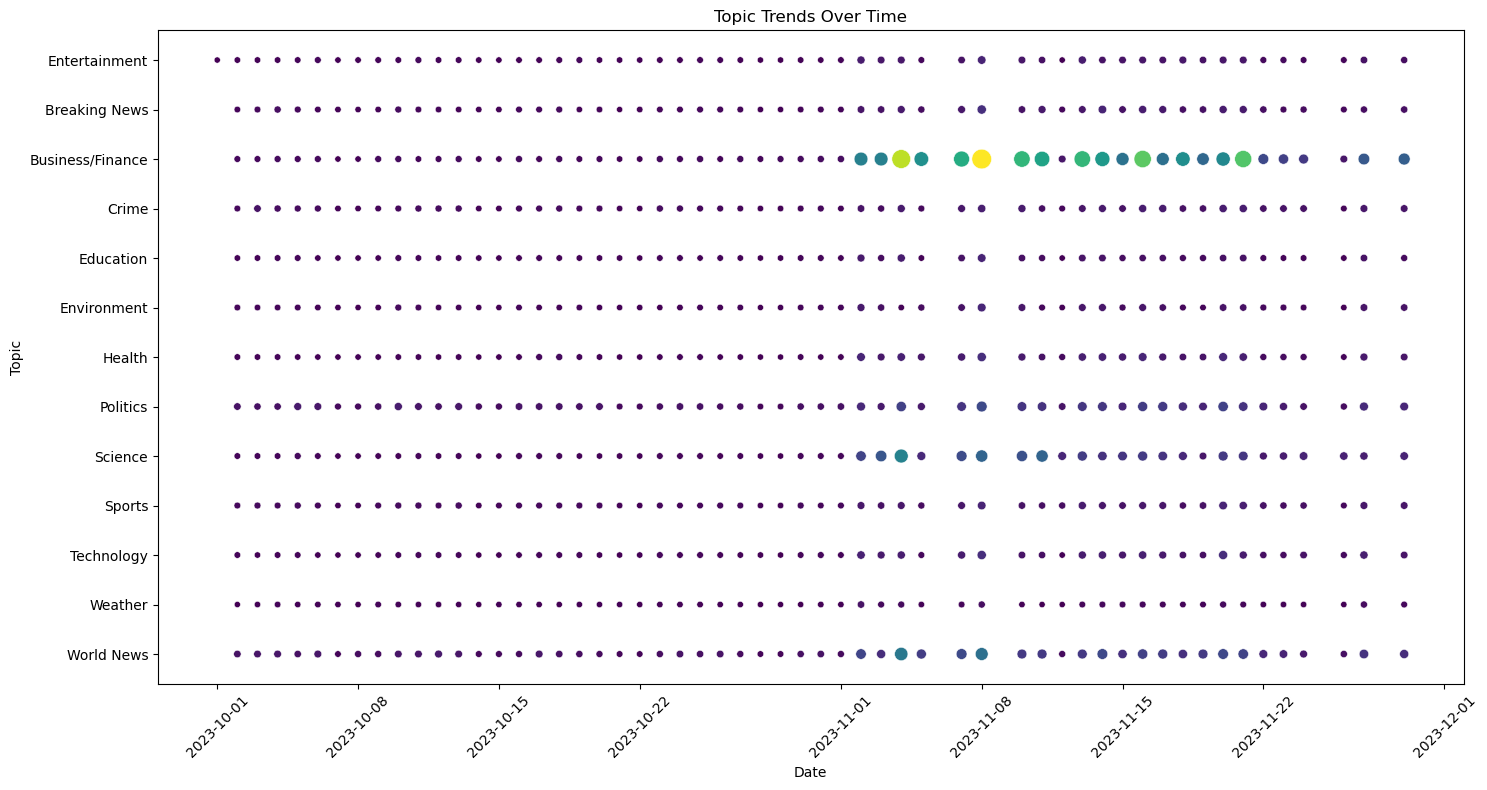

In [14]:
data['published_at'] = pd.to_datetime(data['published_at'],format='ISO8601')

# Extract the date from 'published_at'
data['date'] = data['published_at'].dt.date

data_without_other = data[data["category"] != "Other"]
# Group by date and category to get the count of articles per topic per day
topic_trends = data_without_other.groupby(['date', 'category']).size().reset_index(name='count')

# Plotting the scatter plot
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=topic_trends,
    x='date',
    y='category',
    size='count',
    hue='count',
    palette='viridis',
    sizes=(20, 200),
    legend=None
)

plt.title('Topic Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Topic')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()